In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import numpy as np
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

%matplotlib inline

In [2]:
def sem(data):
    return data.std()/np.sqrt(len(data))


In [12]:
def conn_strength(strOne,strTwo):
#strOne must be a structure in thalamus
#strTwo is a layer of the primary motor cortex

    drive_path = '/Volumes/Brain2016'


    resolution_um=25
    manifest_file = os.path.join(drive_path, "MouseConnectivity","manifest.json")
    mcc = MouseConnectivityCache(manifest_file=manifest_file, resolution=resolution_um)

    all_experiments = mcc.get_experiments(dataframe=True)

    ontology = mcc.get_ontology()

    str1 = ontology[strOne]
    str1_desc = ontology.get_descendants(str1.id)



    # get the adult mouse structures summary structures

    oa = OntologiesApi()
    set_name = [oa.quote_string('Mouse Connectivity - Summary')]
    summary_structures = oa.get_structures(structure_set_names=set_name)
    summary_structure_ids = [ s['id'] for s in summary_structures ]


    cre_str1_experiments = mcc.get_experiments(cre=True, injection_structure_ids=str1['id'])
    cre_str1_exps_df = pd.DataFrame(cre_str1_experiments)

    str1_children = ontology[strTwo]
    #print str1['id']
    #print ('Structure Two ID:',str1_children['id'])


    structure_unionizes_str1 = mcc.get_structure_unionizes([ e['id'] for e in cre_str1_experiments ], 
                                                  is_injection=None,
                                                  structure_ids=[str1['id'], str1_children['id']])

    ipsi_source = structure_unionizes_str1[(structure_unionizes_str1.hemisphere_id == 3) & 
                                       (structure_unionizes_str1.normalized_projection_volume > .8) &
                                       (structure_unionizes_str1.is_injection == True) &
                                       (structure_unionizes_str1.structure_id == float(str1.id))]
    X = ipsi_source.pivot(index='experiment_id', columns='structure_id', values='projection_density')

    ipsi_target = structure_unionizes_str1[(structure_unionizes_str1.hemisphere_id == 3) & 
                                       (structure_unionizes_str1.is_injection == False) &
                                       (structure_unionizes_str1.structure_id == float(str1_children.id))]
    Ydash = ipsi_target.pivot(index='experiment_id', columns='structure_id', values='projection_density')
    Y = Ydash.loc[X.index]


    trans = all_experiments.loc[Y.index]['transgenic-line']

    weight = Y.values/X.values
    
    df = pd.DataFrame(trans)
    expt_ids = df.index.values
    lines = df['transgenic-line'].values
    weight = np.squeeze(weight)
    data_dict = {}
    data_dict['experiment_id']=expt_ids
    data_dict['transgenic_line']=lines
    data_dict['weight']=weight
    
    xy = pd.DataFrame(data_dict)
     
    df1 = xy.sort_values(['transgenic_line', 'weight'], ascending=[True, True])
    #fig = df1.plot( kind='bar', stacked=True, figsize = (35,10),subplots= True, sharex=True);
    #grouped = df1.groupby(['transgenic_line'])
    #columns_to_display = ['weight']

    mean1 =  df1.groupby('transgenic_line')['weight'].mean()
    sd1 = df1.groupby('transgenic_line')['weight'].std()
    sem1 = df1.groupby('transgenic_line')['weight'].sem()
    
    data_dict2 = {}
    data_dict2['mean'] = mean1
    data_dict2['sd'] = sd1
    data_dict2['sem'] = sem1
    df2 = pd.DataFrame(data_dict2)
    df3 = df2.sort_values(['sd'], ascending=[True])
    df3.plot(kind = 'bar',title = 'Variance in Cre Lines',stacked = True)
    
    df1.boxplot(column='weight',by = 'transgenic_line',figsize = (30,10),rot = 90)
    plt.title('Boxplot of variance within a Cre Line')
    plt.xlabel('Cre Line')
    plt.ylabel('Variance in Weight of projection')
    
    return df3
    


,mean,sd,sem
transgenic_line,,,
Slc32a1-IRES-Cre,0.000023,4.369892e-07,3.089980e-07
Gad2-IRES-Cre,0.000006,5.407357e-06,3.823579e-06
Oxtr-Cre_ON66,0.000124,1.581073e-04,1.117988e-04
Crh-IRES-Cre (BL),0.000140,1.592291e-04,7.961453e-05
Calb2-IRES-Cre,0.000183,2.277532e-04,6.574670e-05
Slc6a5-Cre_KF109,0.000317,3.768087e-04,2.664440e-04
Syt17-Cre_NO14,0.000432,4.249357e-04,2.453367e-04
Htr2a-Cre_KM207,0.000718,5.927498e-04,3.422242e-04
Lypd6-Cre_KL156,0.001682,1.626877e-03,9.392781e-04


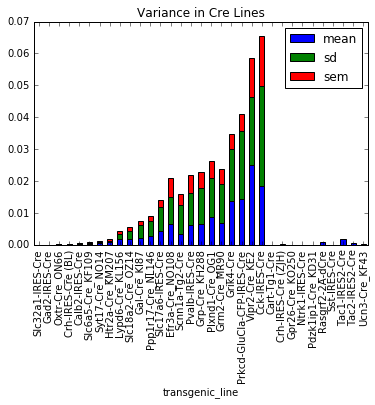

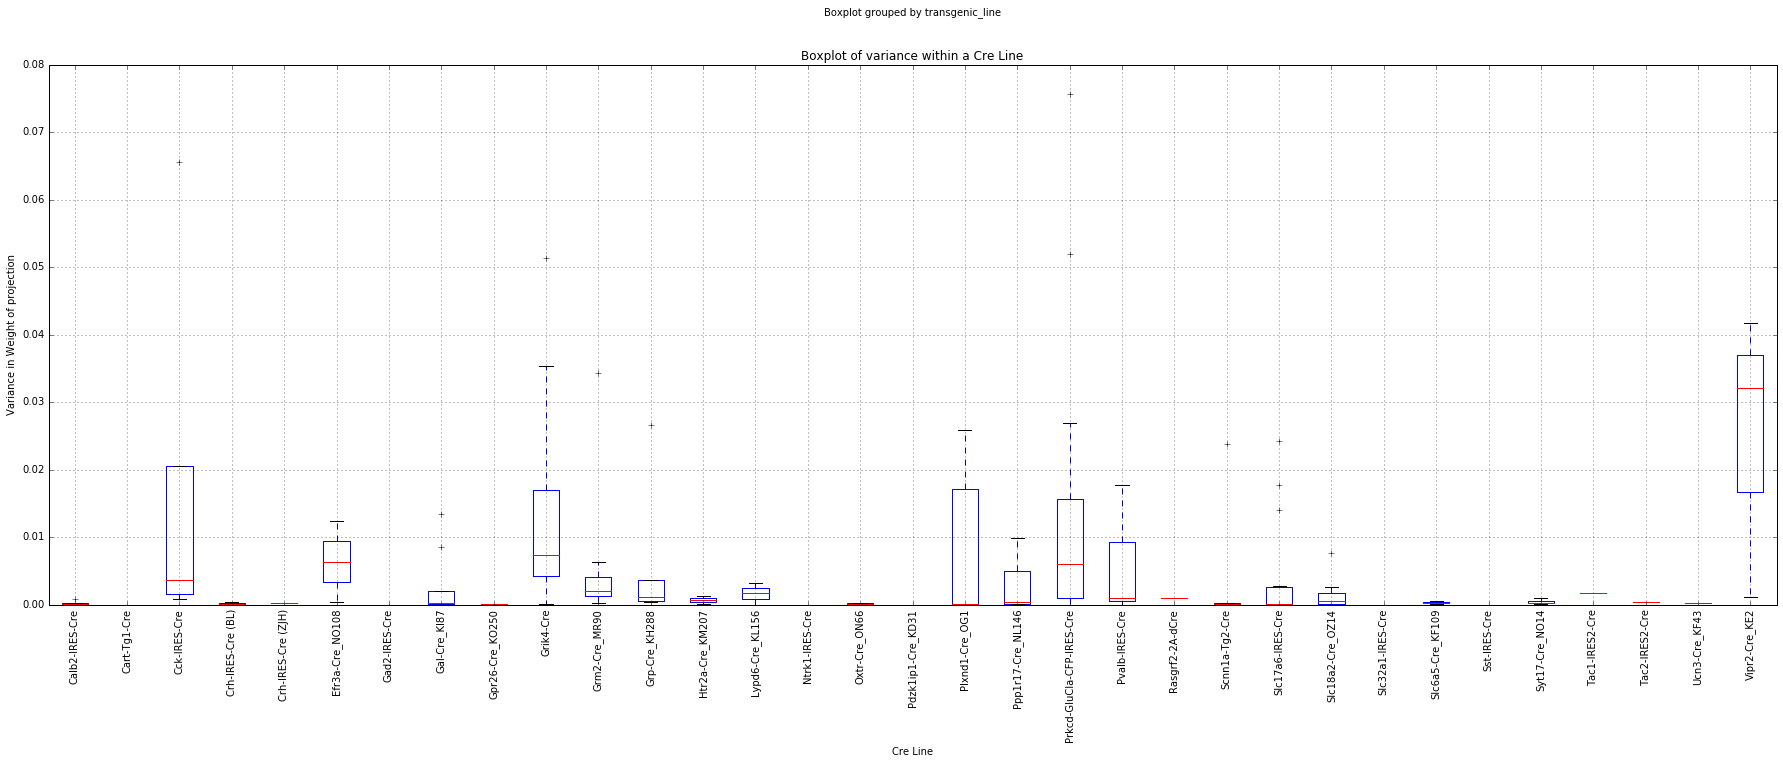

In [13]:
conn_strength('TH','MOp')